This notebook presents statistics of the book data integration.


## Setup


In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statistics as `gender-stats.csv` as part of the integration.  Let's load those:


In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,LOC-MDS,no-author-rec,305932,NaN
1,LOC-MDS,no-book-author,598118,NaN
2,LOC-MDS,unknown,1102373,NaN
3,LOC-MDS,female,736825,NaN
4,LOC-MDS,male,2414561,NaN


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:


In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:


In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.


In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

/tmp/ipykernel_89060/233082166.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  book_counts = link_stats.pivot('dataset', 'gender', 'n_books')


gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ14,247131.0,550289.0,24293.0,244288.0,157140.0,166954.0,866957.0,2257052.0
AZ18,314233.0,669333.0,28300.0,309432.0,243065.0,151433.0,1138027.0,2853823.0
BX-E,40089.0,58599.0,5670.0,15152.0,5703.0,5439.0,17403.0,148055.0
BX-I,71367.0,102840.0,9573.0,31126.0,11557.0,10872.0,34856.0,272191.0
GR-E,223527.0,334124.0,18917.0,111379.0,61224.0,734560.0,NaN,1483731.0
GR-I,225786.0,338392.0,19115.0,113312.0,62332.0,746315.0,NaN,1505252.0
LOC-MDS,736825.0,2414561.0,73411.0,1102373.0,305932.0,598118.0,NaN,5231220.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

/tmp/ipykernel_89060/71450322.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')


gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ14,4905977.0,7090496.0,909797.0,2222075.0,1115464.0,2329752.0,3852790.0
AZ18,12113491.0,15541958.0,2005910.0,4980474.0,3347274.0,2758328.0,9908335.0
BX-E,138698.0,182935.0,46970.0,24009.0,7129.0,7246.0,19828.0
BX-I,392413.0,466570.0,116881.0,67273.0,18583.0,18935.0,47065.0
GR-E,35570655.0,33133627.0,14015868.0,3717539.0,1031982.0,11094188.0,NaN
GR-I,81501002.0,69838115.0,23242103.0,10844936.0,3541627.0,29517391.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:


In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:


In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?


In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ14,0.109493,0.243809,0.010763,0.108233,0.069622,0.073970,0.384110
AZ18,0.110109,0.234539,0.009917,0.108427,0.085172,0.053063,0.398773
BX-E,0.270771,0.395792,0.038297,0.102340,0.038519,0.036736,0.117544
BX-I,0.262195,0.377823,0.035170,0.114354,0.042459,0.039943,0.128057
GR-E,0.150652,0.225192,0.012750,0.075067,0.041264,0.495076,NaN
GR-I,0.149999,0.224808,0.012699,0.075278,0.041410,0.495807,NaN
LOC-MDS,0.140851,0.461567,0.014033,0.210730,0.058482,0.114336,NaN


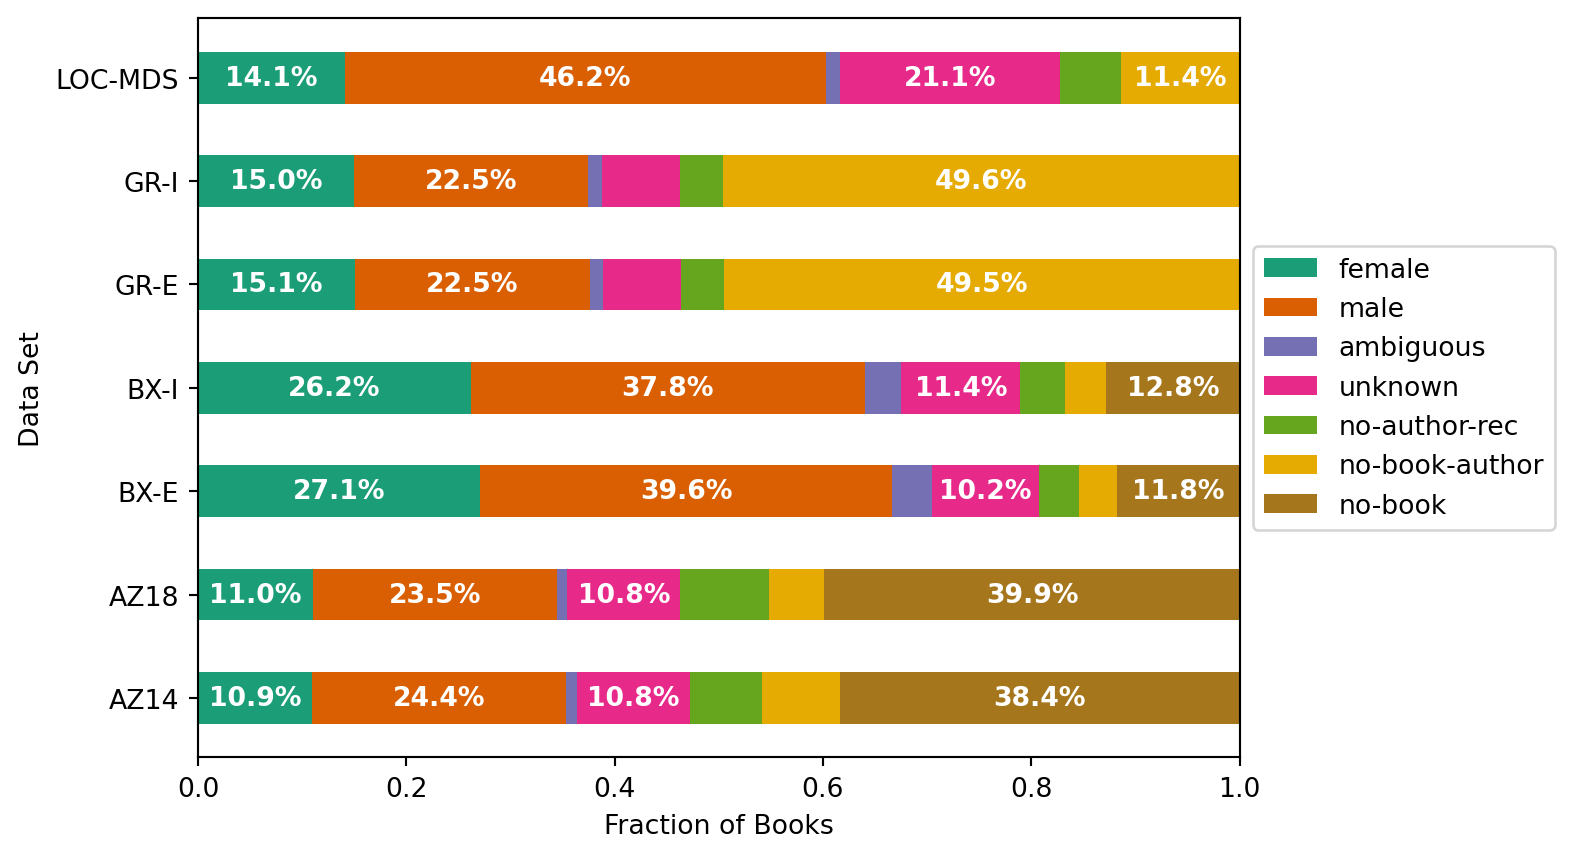

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ14,0.109493,0.243809,0.010763,0.108233,0.527702
AZ18,0.110109,0.234539,0.009917,0.108427,0.537008
BX-E,0.270771,0.395792,0.038297,0.102340,0.192800
BX-I,0.262195,0.377823,0.035170,0.114354,0.210459
GR-E,0.150652,0.225192,0.012750,0.075067,0.536340
GR-I,0.149999,0.224808,0.012699,0.075278,0.537217
LOC-MDS,0.140851,0.461567,0.014033,0.210730,0.172818


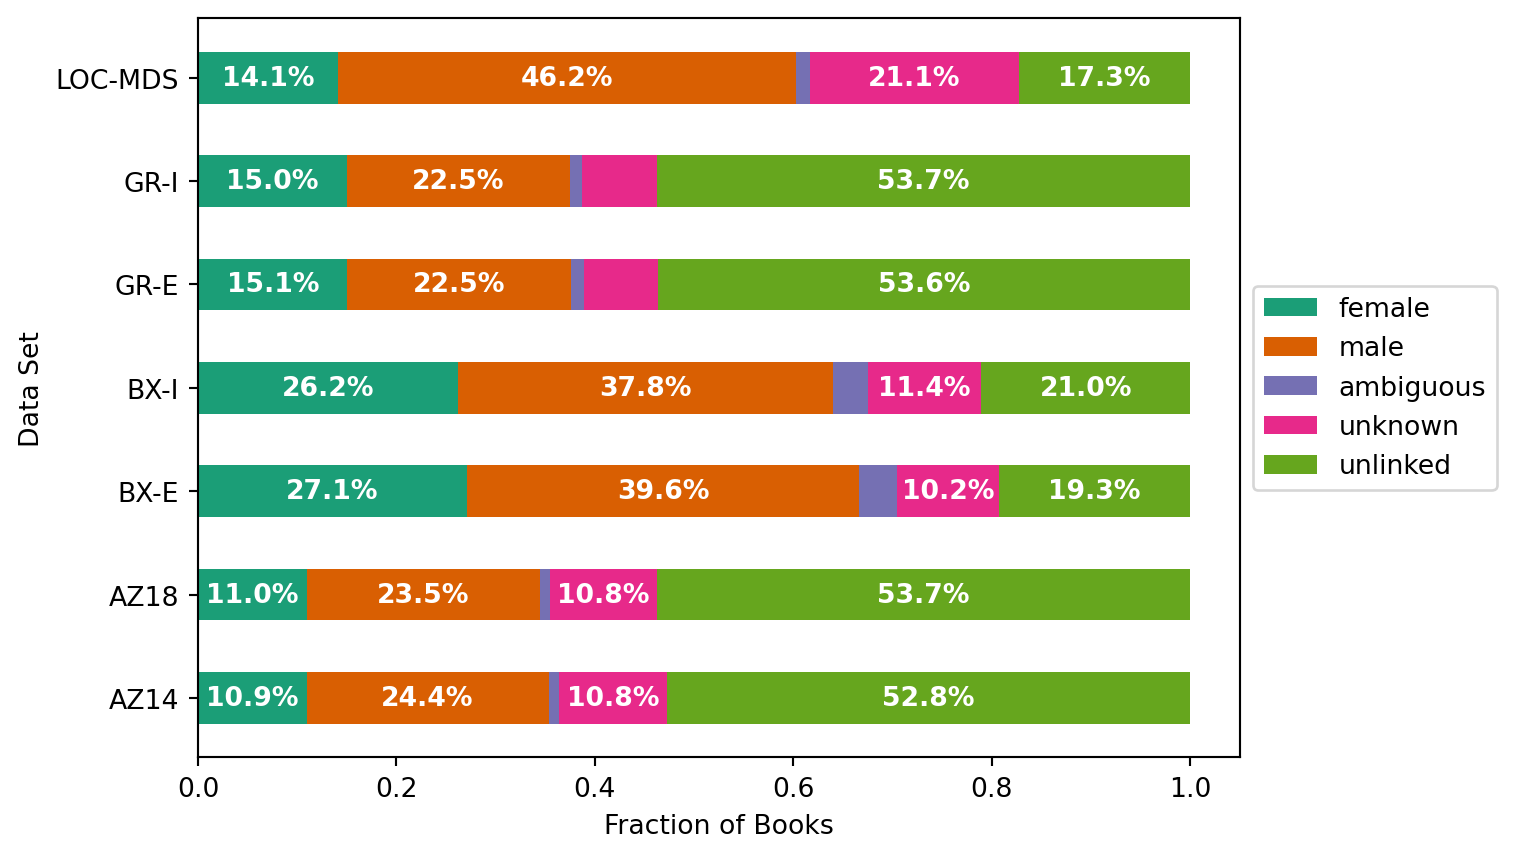

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

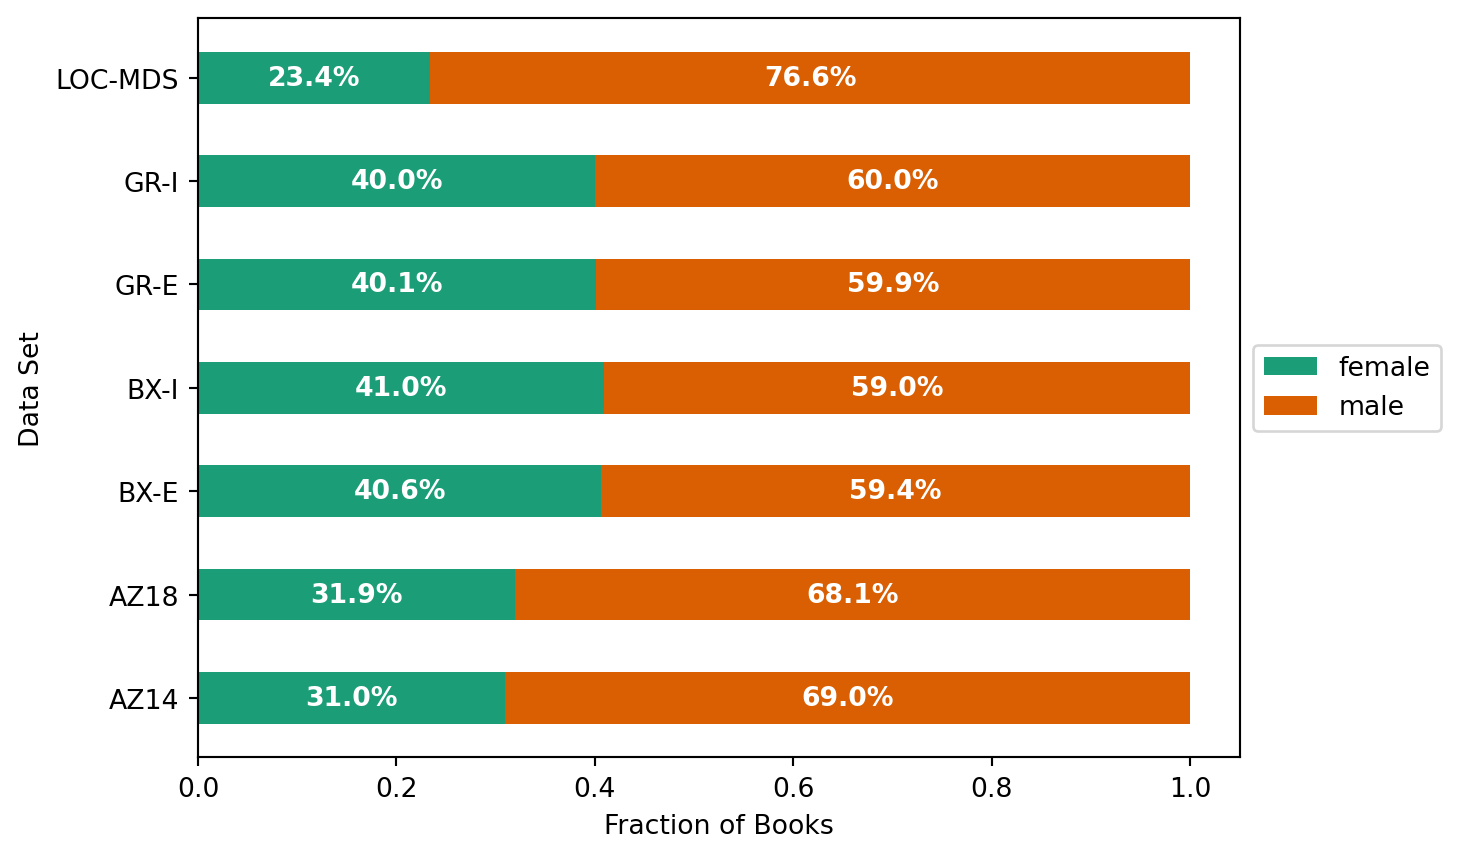

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?


In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ14,0.218759,0.316168,0.040568,0.099083,0.049739,0.103885,0.171797
AZ18,0.239133,0.306815,0.039599,0.098320,0.066079,0.054452,0.195601
BX-E,0.324960,0.428605,0.110048,0.056252,0.016703,0.016977,0.046456
BX-I,0.347970,0.413729,0.103644,0.059654,0.016478,0.016791,0.041735
GR-E,0.360889,0.336164,0.142201,0.037717,0.010470,0.112558,NaN
GR-I,0.373028,0.319647,0.106378,0.049637,0.016210,0.135100,NaN


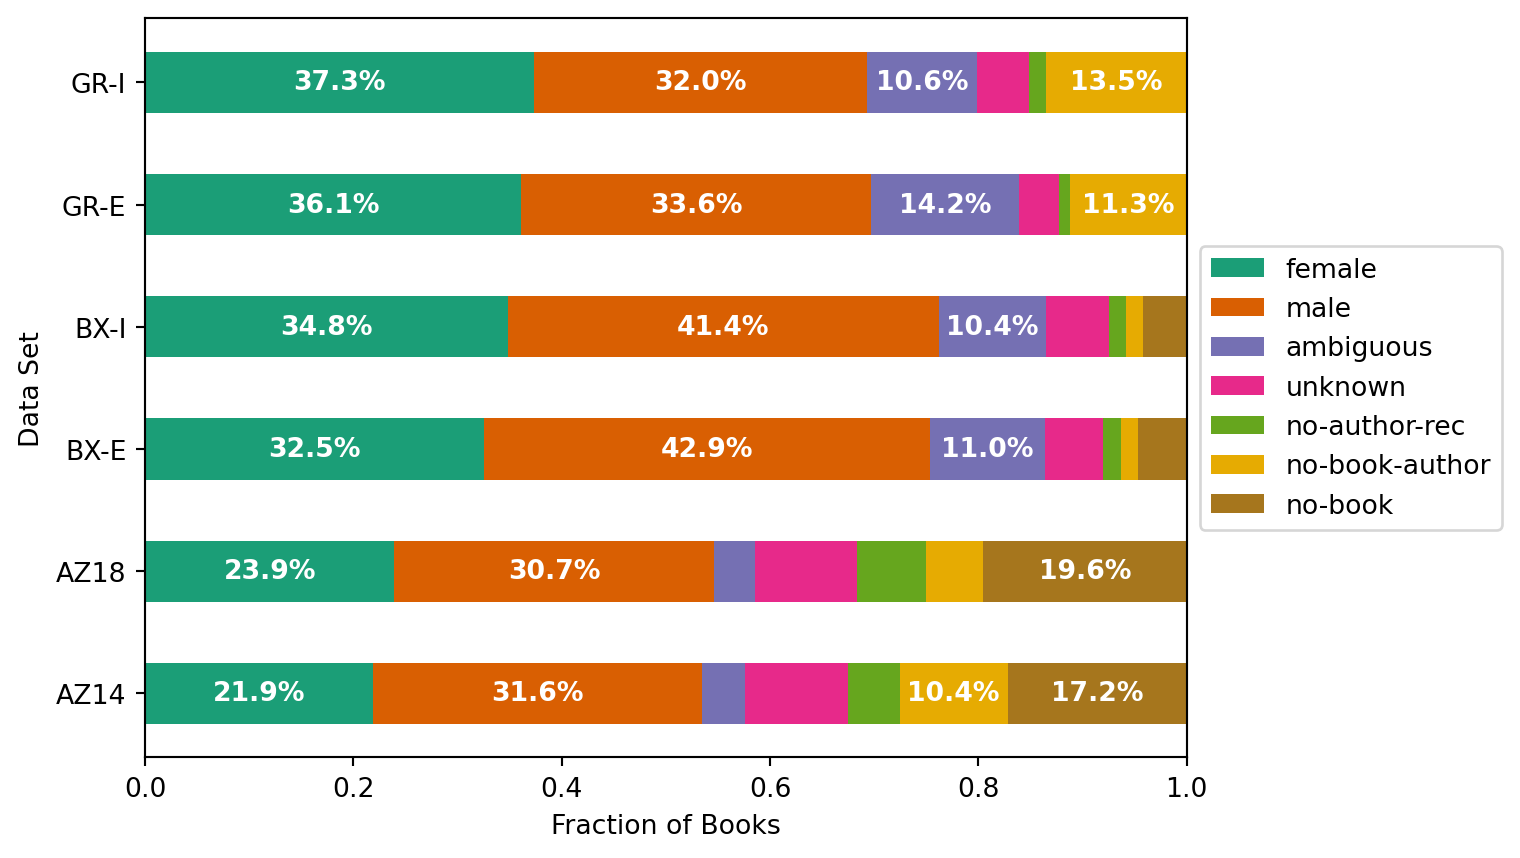

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ14,0.218759,0.316168,0.040568,0.099083,0.325421
AZ18,0.239133,0.306815,0.039599,0.098320,0.316133
BX-E,0.324960,0.428605,0.110048,0.056252,0.080135
BX-I,0.347970,0.413729,0.103644,0.059654,0.075004
GR-E,0.360889,0.336164,0.142201,0.037717,0.123029
GR-I,0.373028,0.319647,0.106378,0.049637,0.151310


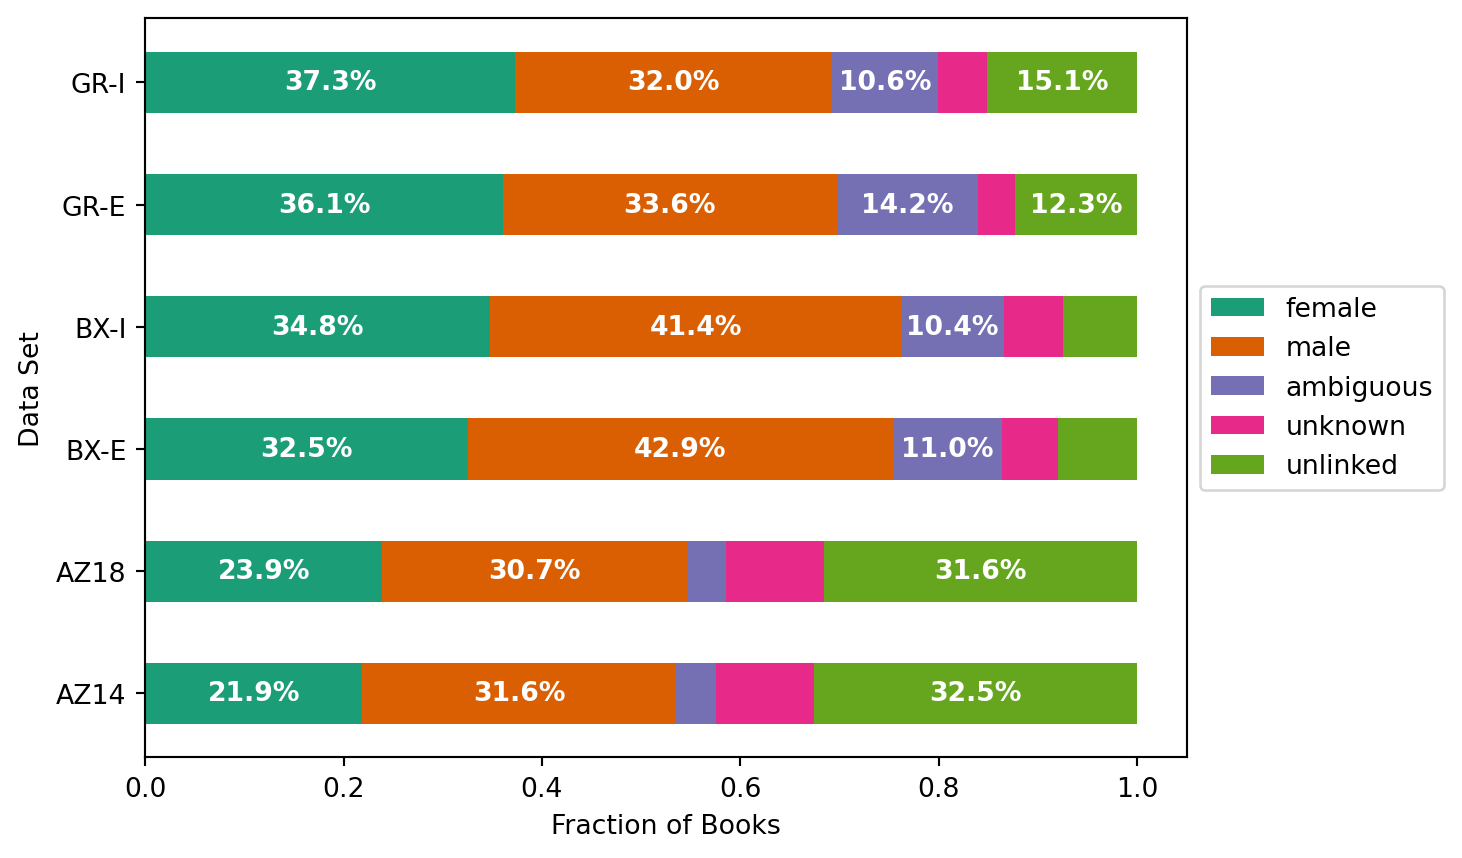

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

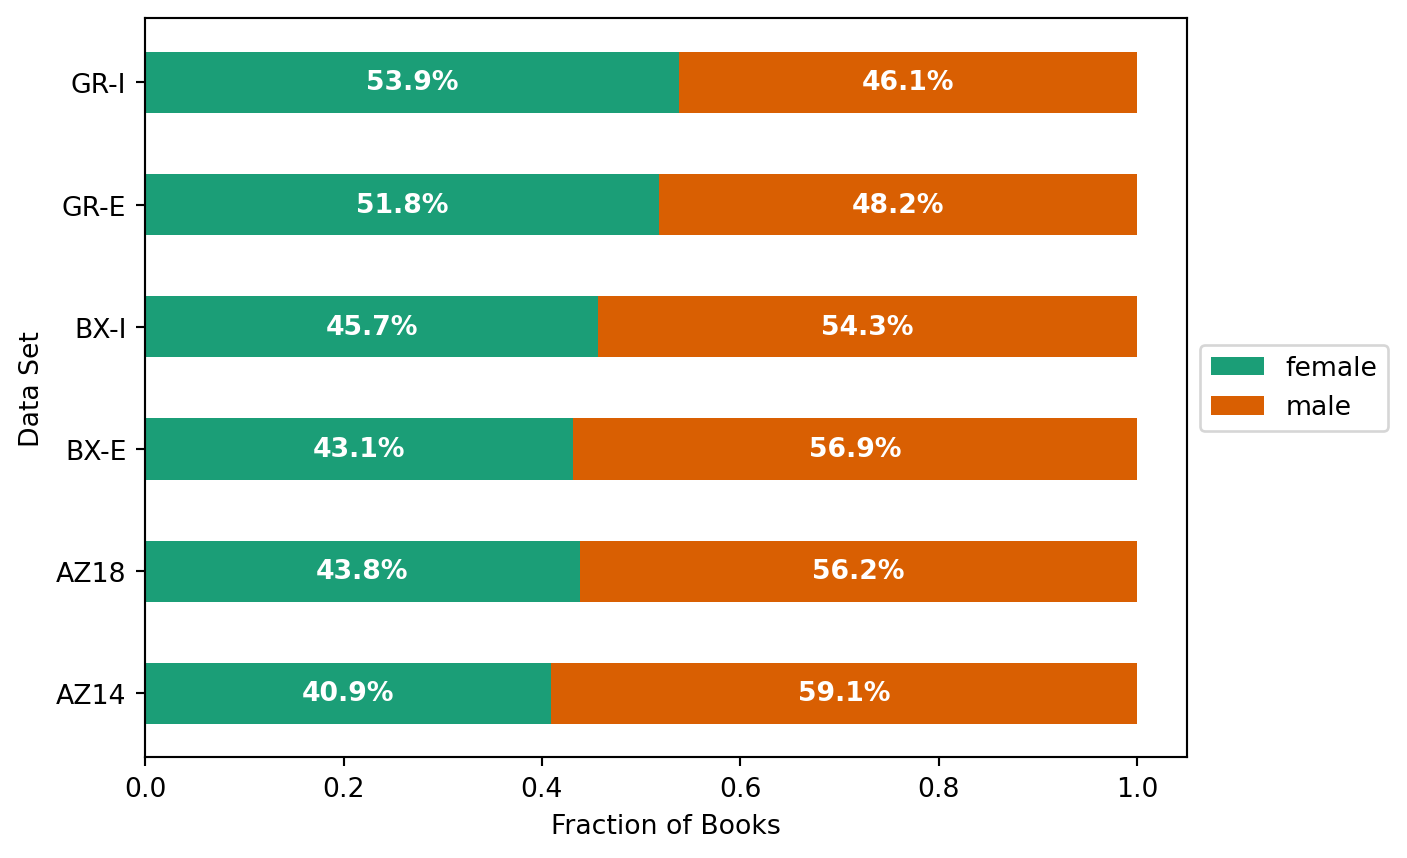

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.


In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ14       0.364065
AZ18       0.354565
BX-E       0.704860
BX-I       0.675188
GR-E       0.388593
GR-I       0.387505
LOC-MDS    0.616452
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')